> ### `Importing Required libraies`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
!pip install xgboost
import xgboost as xgb



---



> ### `Data Collection`

**about the dataframes**

*   **df1** -[ S&P CoreLogic Case-Shiller U.S. National Home Price Index (CSUSHPISA)
](https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CSUSHPISA&scale=left&cosd=1987-01-01&coed=2024-10-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-01-09&revision_date=2025-01-09&nd=1987-01-01)
*   **df2** - [us_national_market_tracker dataset](https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker/us_national_market_tracker.tsv000.gz)



In [3]:
df1 = pd.read_excel('ds1.xlsx', sheet_name='Monthly')
df2 = pd.read_csv('ds2.csv')

> ### `Data Preprocessing`
 the steps for datapreprocessing

In [22]:
df1["observation_date"] = pd.to_datetime(df1["observation_date"])

df2["period_begin"] = pd.to_datetime(df2["period_begin"])
df2["period_end"] = pd.to_datetime(df2["period_end"])

# Filter rows for "national" region only
df2 = df2[df2["region_type"] == "national"]

# Selecting relevant columns from df2
df2_filtered = df2[
    [
        "period_begin", "period_end", "median_sale_price", "median_list_price",
        "median_ppsf", "homes_sold", "pending_sales", "new_listings", "inventory",
        "months_of_supply", "median_dom", "avg_sale_to_list"
    ]
]

# Merge the datasets using an inner join on the date columns
merged_data = pd.merge(
    df1,
    df2_filtered,
    left_on="observation_date",
    right_on="period_begin",
    how="inner"
)

# preview of the merged dataset
print("Merged dataset preview:")
merged_data.head()


Merged dataset preview:


,observation_date,CSUSHPISA,period_begin,period_end,median_sale_price,median_list_price,median_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list
0,2012-01-01,136.602,2012-01-01,2012-01-31,143553.5517,159672.2061,122.159388,47505.16794,56386.23651,65513.85430,2.702115e+05,5.833589,90.813512,0.957937
1,2012-01-01,136.602,2012-01-01,2012-01-31,177702.1310,193472.2717,92.020726,307982.69690,363872.81040,446247.37730,1.744645e+06,5.830607,83.106686,0.963538
2,2012-01-01,136.602,2012-01-01,2012-01-31,158876.0000,183585.0000,90.000000,274711.00000,370791.00000,486238.00000,2.064554e+06,7.515352,96.000000,0.956202
3,2012-01-01,136.602,2012-01-01,2012-01-31,170747.8202,186581.3445,94.354369,395277.87790,468270.55740,576001.77350,2.246803e+06,5.937037,83.610306,0.962578
4,2012-01-01,136.602,2012-01-01,2012-01-31,165518.3816,163135.3887,107.599612,31868.48372,37684.03683,44856.85224,1.685429e+05,5.437027,75.847626,0.966136


In [5]:
## checking for null values in the dataset

null_counts = merged_data.isnull().sum()
null_counts

,0
observation_date,0
CSUSHPISA,0
period_begin,0
period_end,0
median_sale_price,0
median_list_price,0
median_ppsf,0
homes_sold,0
pending_sales,0
new_listings,0


In [6]:
## rounding off the decimals

merged_data1 = merged_data.copy()
# Function to round to nearest 5 in the second decimal place
def round_to_nearest_5(x):
    return round(x * 20) / 20

# columns with decimal values
decimal_columns = merged_data1.select_dtypes(include=np.number).columns.tolist()

# Iterating through the decimal columns and round them
for col in decimal_columns:
    merged_data1[col] = merged_data1[col].apply(round_to_nearest_5)

merged_data1

,observation_date,CSUSHPISA,period_begin,period_end,median_sale_price,median_list_price,median_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list
0,2012-01-01,136.6,2012-01-01,2012-01-31,143553.55,159672.20,122.15,47505.15,56386.25,65513.85,270211.45,5.85,90.80,0.95
1,2012-01-01,136.6,2012-01-01,2012-01-31,177702.15,193472.25,92.00,307982.70,363872.80,446247.40,1744645.45,5.85,83.10,0.95
2,2012-01-01,136.6,2012-01-01,2012-01-31,158876.00,183585.00,90.00,274711.00,370791.00,486238.00,2064554.00,7.50,96.00,0.95
3,2012-01-01,136.6,2012-01-01,2012-01-31,170747.80,186581.35,94.35,395277.90,468270.55,576001.75,2246803.00,5.95,83.60,0.95
4,2012-01-01,136.6,2012-01-01,2012-01-31,165518.40,163135.40,107.60,31868.50,37684.05,44856.85,168542.85,5.45,75.85,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2024-01-01,316.1,2024-01-01,2024-01-31,420538.95,431382.65,231.90,416745.40,478279.60,531379.30,1145815.10,2.80,37.55,1.00
139,2024-01-01,316.1,2024-01-01,2024-01-31,359118.00,383094.00,221.00,29465.00,44088.00,46826.00,87731.00,3.00,43.00,1.00
140,2024-01-01,316.1,2024-01-01,2024-01-31,350781.50,363212.85,309.15,43748.85,50785.75,61359.80,149428.35,3.40,39.40,1.00
141,2024-01-01,316.1,2024-01-01,2024-01-31,419986.15,430025.85,233.05,407818.80,466113.15,517519.55,1114325.25,2.80,36.80,1.00


> ### `Data Analysis`

In [7]:
### Descriptive Data Statistics
numeric_cols = merged_data1.select_dtypes(include=np.number)

summary_stats = numeric_cols.describe(percentiles=[0.25, 0.5, 0.75, 0.9])


summary_stats

,CSUSHPISA,median_sale_price,median_list_price,median_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,1.430000e+02,143.000000,143.000000,143.000000
mean,210.565385,269698.296503,287596.312587,161.441958,225700.669930,280266.154545,289240.704895,7.704363e+05,3.765734,53.261538,0.981119
std,56.219268,77073.382089,80031.022218,51.141821,191744.023909,226861.764682,229828.766205,6.714713e+05,1.539085,18.125132,0.024325
min,136.600000,134703.000000,158602.000000,71.000000,6777.000000,9313.000000,9139.000000,2.477900e+04,1.050000,14.750000,0.950000
25%,168.600000,210371.775000,222924.500000,121.900000,39894.000000,51443.100000,54059.275000,1.274394e+05,2.825000,41.500000,0.950000
50%,198.300000,259264.450000,275302.000000,151.000000,256728.000000,361380.000000,378120.000000,7.189820e+05,3.550000,51.000000,1.000000
75%,239.700000,327127.900000,349282.500000,206.500000,387220.625000,480086.675000,492976.300000,1.392693e+06,4.575000,64.675000,1.000000
90%,297.550000,392427.000000,411170.520000,224.800000,486734.920000,577331.080000,578489.960000,1.708907e+06,5.700000,77.800000,1.000000
max,316.100000,438181.650000,501274.000000,309.150000,668696.900000,696754.250000,638310.600000,2.246803e+06,8.900000,102.000000,1.000000


`plots to understand the data`

Highly Correlated Features with CSUSHPISA:
 CSUSHPISA            1.000000
median_sale_price    0.953000
median_list_price    0.950175
median_ppsf          0.858926
avg_sale_to_list     0.577849
homes_sold           0.044830
pending_sales        0.029357
new_listings        -0.044501
inventory           -0.291059
months_of_supply    -0.693707
median_dom          -0.741278
Name: CSUSHPISA, dtype: float64


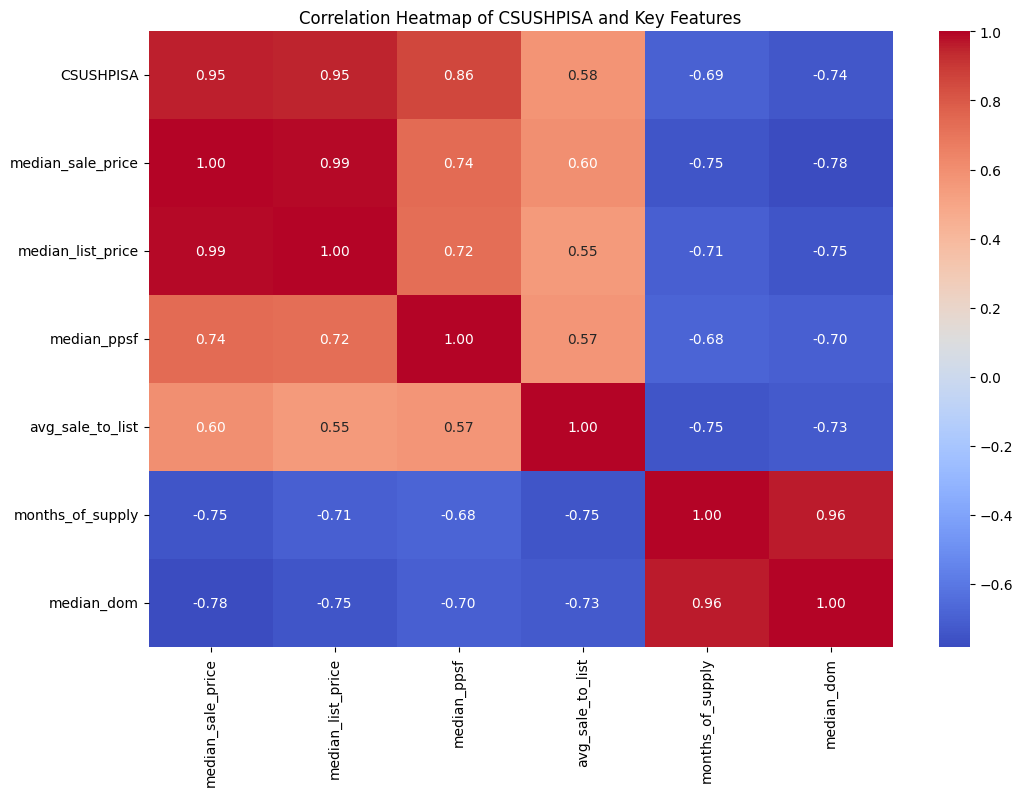

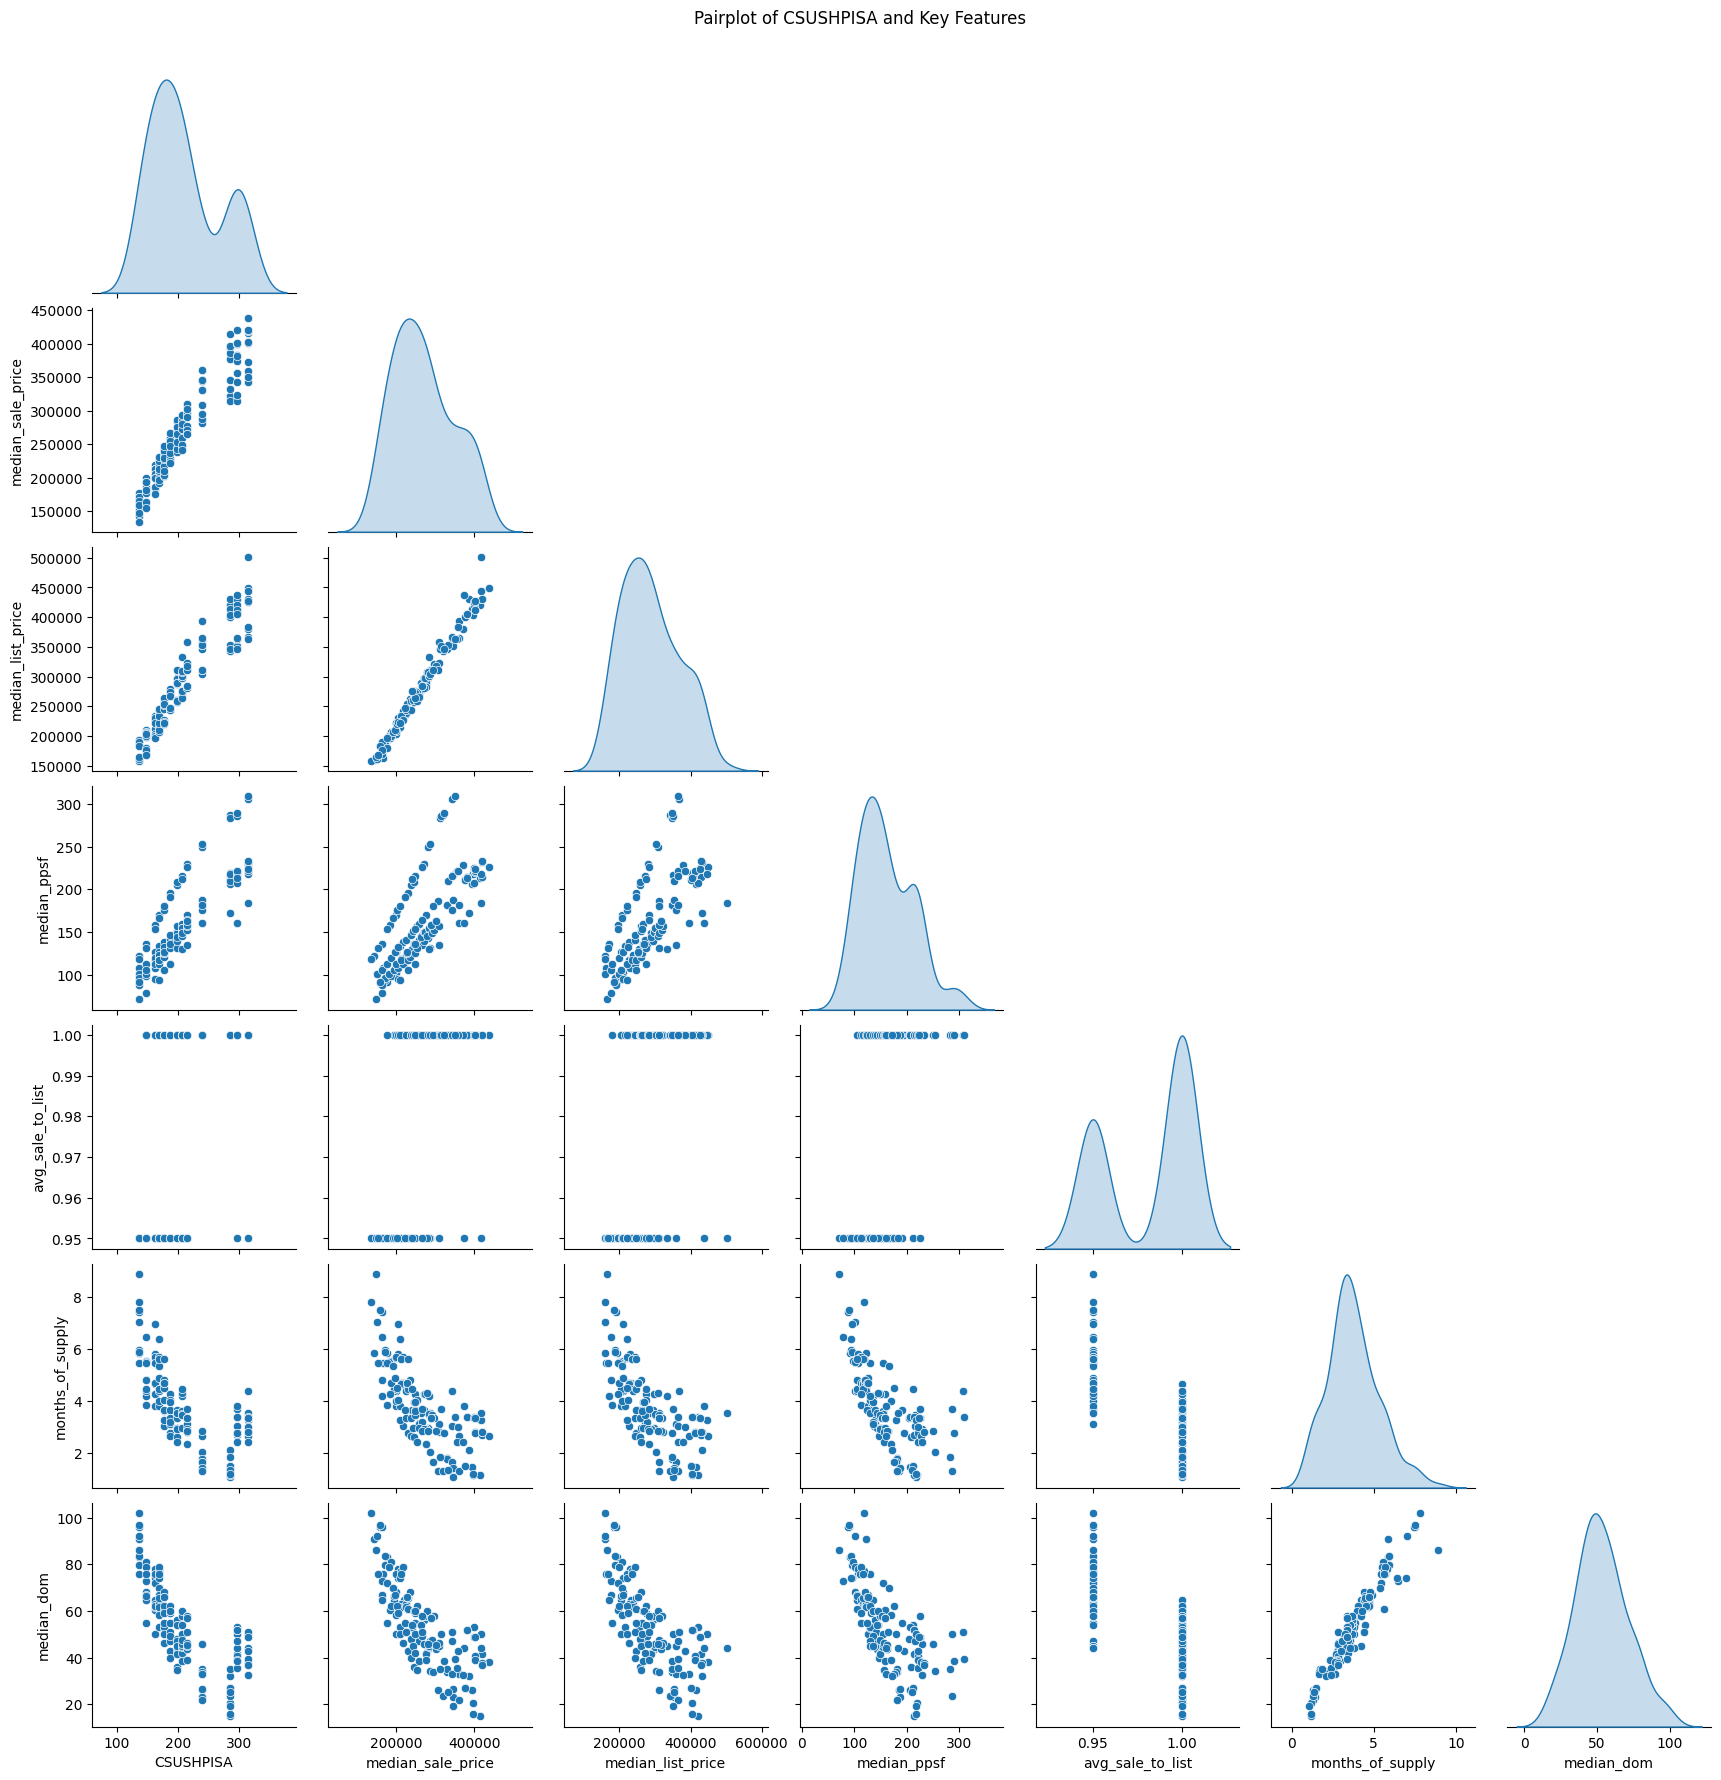

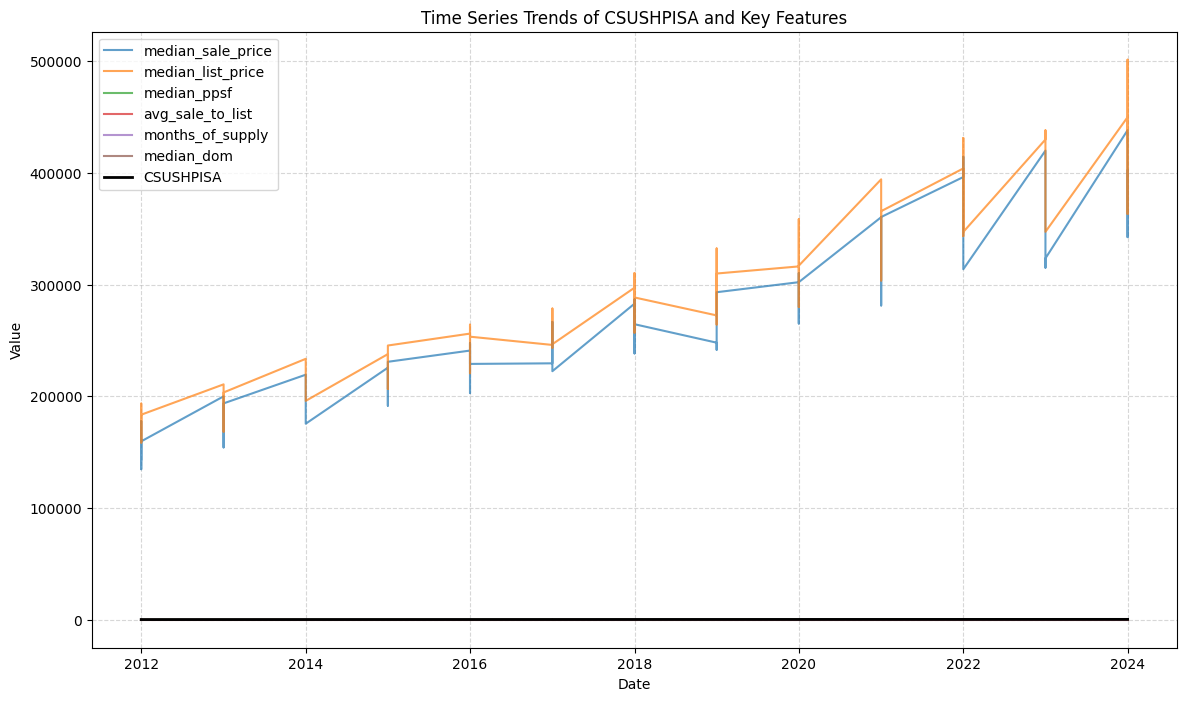

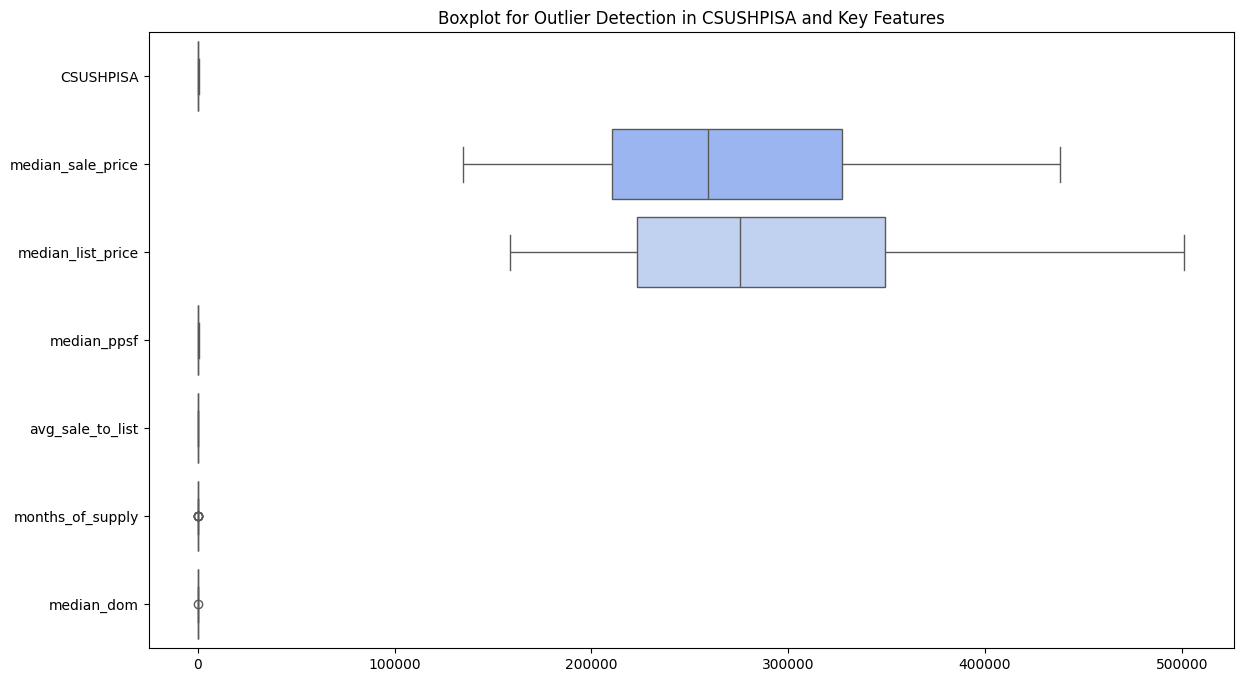

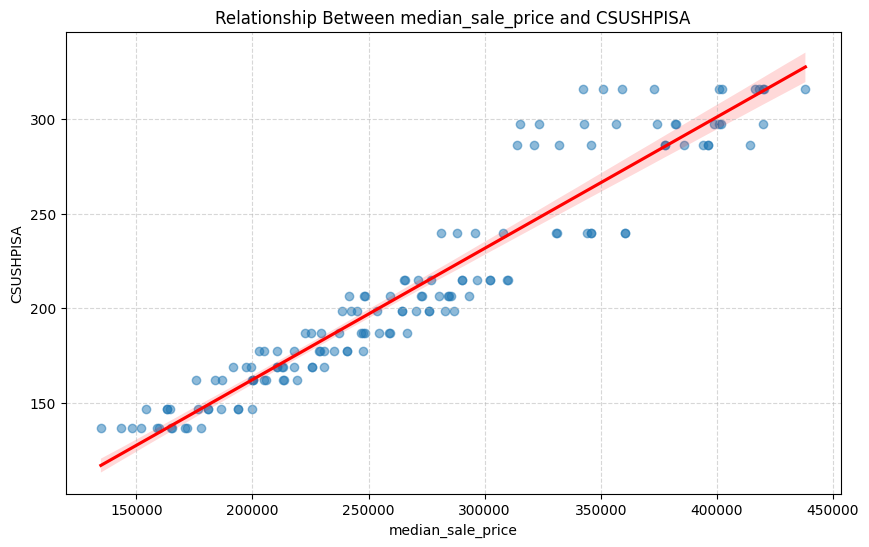

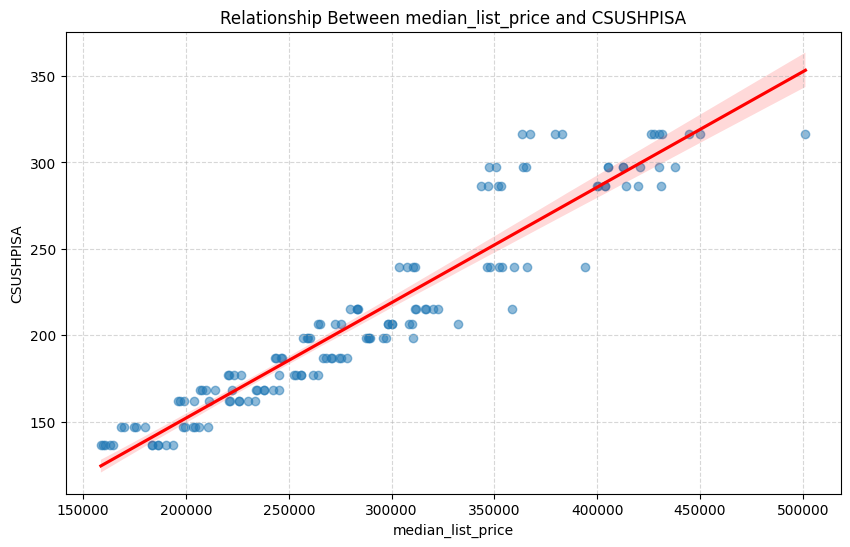

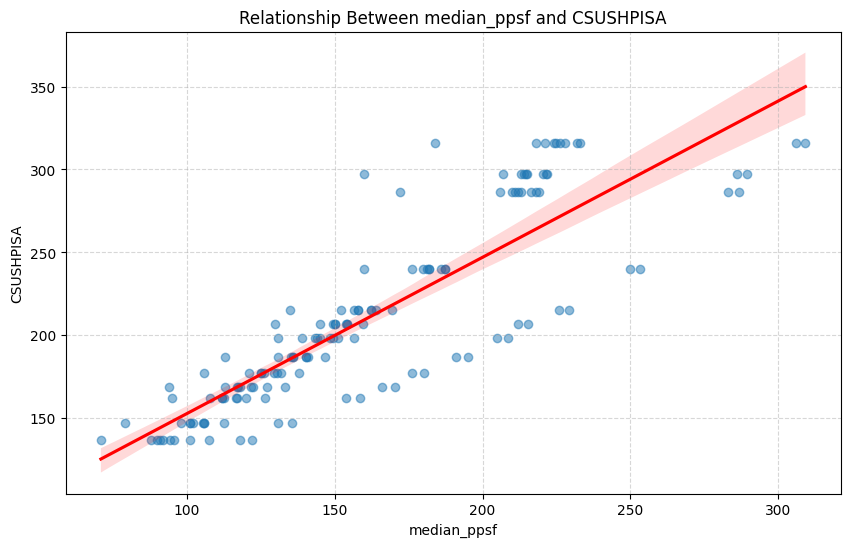

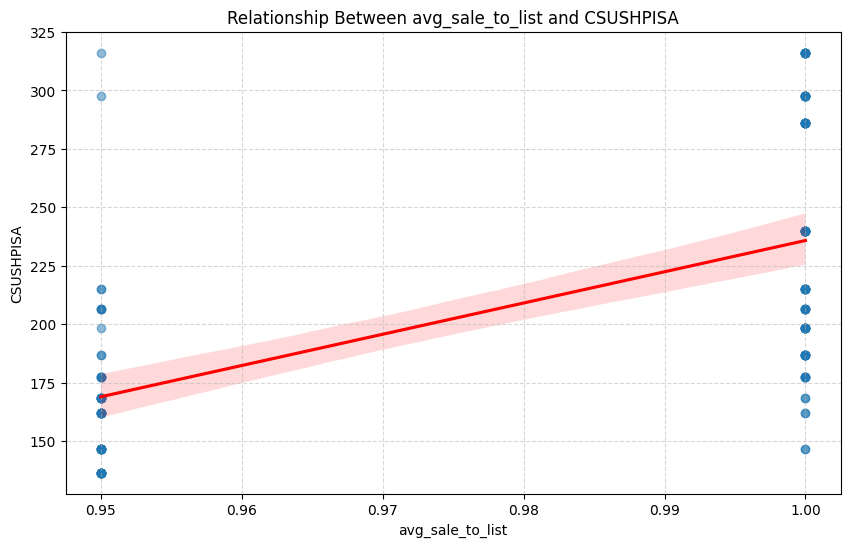

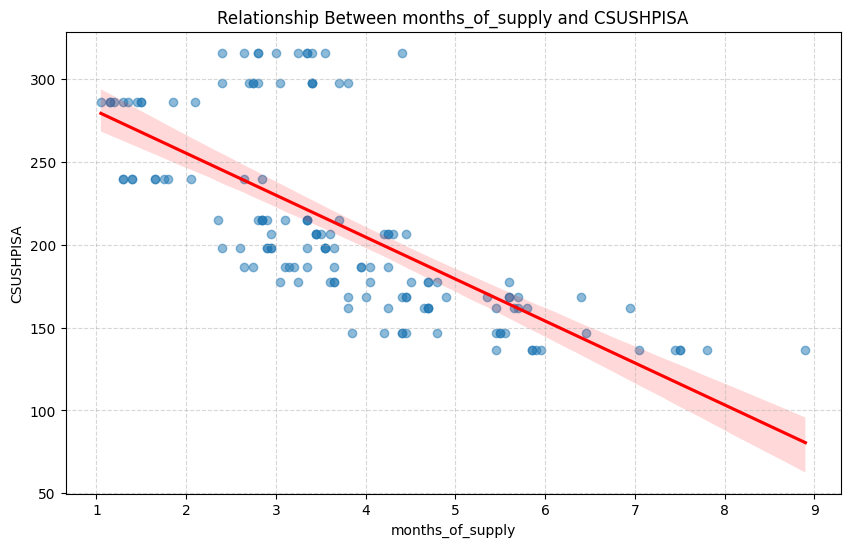

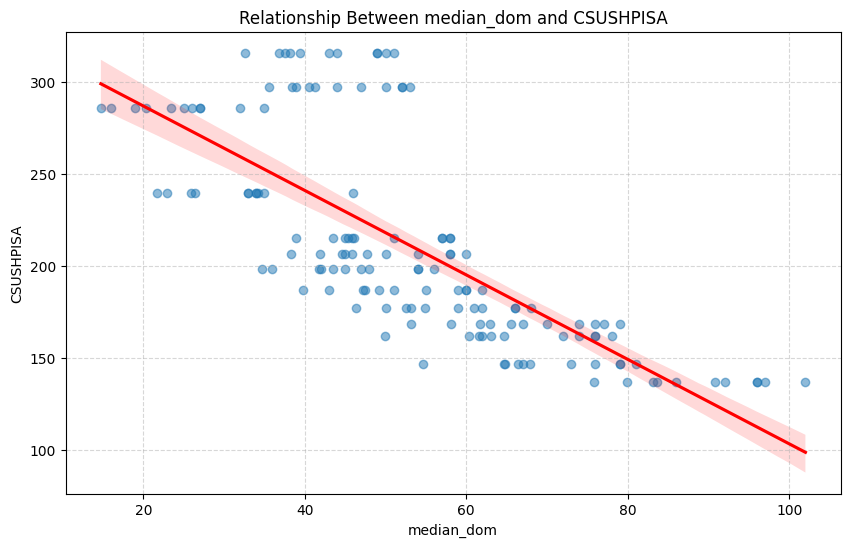

In [8]:
def refined_eda(df):
    # Step 1: Correlation Analysis
    numerical_df = df.select_dtypes(include=["number"])  # Excluding the datetime columns
    correlation_matrix = numerical_df.corr()
    target_correlation = correlation_matrix["CSUSHPISA"].sort_values(ascending=False)

    # taking features with correlation > 0.5 or < -0.5
    significant_features = target_correlation[
        (target_correlation > 0.5) | (target_correlation < -0.5)
    ].index.tolist()
    significant_features.remove("CSUSHPISA")  # Excluding the target itself

    print("Highly Correlated Features with CSUSHPISA:\n", target_correlation)

    # Step 2: Visualizations for Significant Features
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix.loc[["CSUSHPISA"] + significant_features, significant_features],
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
    )
    plt.title("Correlation Heatmap of CSUSHPISA and Key Features")
    plt.show()

    # Step 3: Pairwise Relationships
    selected_features = ["CSUSHPISA"] + significant_features
    sns.pairplot(numerical_df[selected_features], diag_kind="kde", corner=True)
    plt.suptitle("Pairplot of CSUSHPISA and Key Features", y=1.02)
    plt.show()

    # Step 4: Time Series Analysis
    plt.figure(figsize=(14, 8))
    for feature in significant_features:
        plt.plot(df["observation_date"], df[feature], label=feature, alpha=0.7)
    plt.plot(df["observation_date"], df["CSUSHPISA"], label="CSUSHPISA", color="black", linewidth=2)
    plt.title("Time Series Trends of CSUSHPISA and Key Features")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Step 5: Boxplot for Outlier Detection
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=numerical_df[selected_features], orient="h", palette="coolwarm")
    plt.title("Boxplot for Outlier Detection in CSUSHPISA and Key Features")
    plt.show()

    # Step 6: Individual Plots for Top Factors
    for feature in significant_features:
        plt.figure(figsize=(10, 6))
        sns.regplot(
            x=feature, y="CSUSHPISA", data=numerical_df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}
        )
        plt.title(f"Relationship Between {feature} and CSUSHPISA")
        plt.xlabel(feature)
        plt.ylabel("CSUSHPISA")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

# Applying refined EDA on the dataset
refined_eda(merged_data1)


> ### `Feature Engineering`
Extracting the feature with the highest importance for predicting `CSUSHPISA`

In [9]:
def feature_engineering(df):
    # Step 1: Lagged Features
    lagged_columns = ["median_sale_price", "inventory", "new_listings", "homes_sold"]
    for col in lagged_columns:
        for lag in [1, 3, 6]:  # Lags of 1, 3, and 6 months
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Step 2: Seasonality Adjustments - features
    # Extracting months to analyze seasonality
    df["month"] = df["observation_date"].dt.month
    df["year"] = df["observation_date"].dt.year

    # Add seasonal features
    df["is_spring"] = df["month"].isin([3, 4, 5]).astype(int)
    df["is_summer"] = df["month"].isin([6, 7, 8]).astype(int)
    df["is_fall"] = df["month"].isin([9, 10, 11]).astype(int)
    df["is_winter"] = df["month"].isin([12, 1, 2]).astype(int)

    seasonal_avg = df.groupby("month")["median_sale_price"].transform("mean")
    df["median_sale_price_seasonal_adjusted"] = df["median_sale_price"] / seasonal_avg

    # Step 3: Derived Metrics
    # Inventory-to-sales ratio
    df["inventory_to_sales"] = df["inventory"] / df["homes_sold"]

    # Inventory-to-new-listings ratio
    df["inventory_to_new_listings"] = df["inventory"] / df["new_listings"]

    # Months of supply adjusted by sales
    df["adjusted_months_of_supply"] = df["months_of_supply"] / df["homes_sold"]

    # Creating additional market metrics
    df["price_per_inventory"] = df["median_sale_price"] / df["inventory"]
    df["price_per_homes_sold"] = df["median_sale_price"] / df["homes_sold"]

    # Step 4: Dropping NA values after lagging
    df = df.dropna().reset_index(drop=True)

    # Step 5: Log Transformation for Skewed Features
    skewed_features = ["median_sale_price", "inventory", "new_listings", "homes_sold"]
    for col in skewed_features:
        df[f"log_{col}"] = df[col].apply(lambda x: np.log1p(x) if x > 0 else 0)

    print("Feature Engineering Completed")
    return df

# Applying Feature Engineering to merged_data1
enhanced_data = feature_engineering(merged_data1)


Feature Engineering Completed


In [10]:
enhanced_data.columns

Index(['observation_date', 'CSUSHPISA', 'period_begin', 'period_end',
       'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold',
       'pending_sales', 'new_listings', 'inventory', 'months_of_supply',
       'median_dom', 'avg_sale_to_list', 'median_sale_price_lag1',
       'median_sale_price_lag3', 'median_sale_price_lag6', 'inventory_lag1',
       'inventory_lag3', 'inventory_lag6', 'new_listings_lag1',
       'new_listings_lag3', 'new_listings_lag6', 'homes_sold_lag1',
       'homes_sold_lag3', 'homes_sold_lag6', 'month', 'year', 'is_spring',
       'is_summer', 'is_fall', 'is_winter',
       'median_sale_price_seasonal_adjusted', 'inventory_to_sales',
       'inventory_to_new_listings', 'adjusted_months_of_supply',
       'price_per_inventory', 'price_per_homes_sold', 'log_median_sale_price',
       'log_inventory', 'log_new_listings', 'log_homes_sold'],
      dtype='object')

In [11]:
enhanced_data

,observation_date,CSUSHPISA,period_begin,period_end,median_sale_price,median_list_price,median_ppsf,homes_sold,pending_sales,new_listings,...,median_sale_price_seasonal_adjusted,inventory_to_sales,inventory_to_new_listings,adjusted_months_of_supply,price_per_inventory,price_per_homes_sold,log_median_sale_price,log_inventory,log_new_listings,log_homes_sold
0,2012-01-01,136.6,2012-01-01,2012-01-31,152198.00,160420.00,101.00,22090.00,30508.00,38585.00,...,0.564327,7.036442,4.028379,0.000319,0.979175,6.889905,11.932944,11.953989,10.560645,10.002926
1,2012-01-01,136.6,2012-01-01,2012-01-31,148058.00,164294.00,71.00,6865.00,9410.00,13302.00,...,0.548976,8.910852,4.598782,0.001296,2.420316,21.567079,11.905366,11.021478,9.495745,8.834337
2,2012-01-01,136.6,2012-01-01,2012-01-31,171650.05,186478.55,95.70,386652.05,457155.10,535565.05,...,0.636452,5.640796,4.072382,0.000015,0.078702,0.443939,12.053219,14.595306,13.191080,12.865283
3,2012-01-01,136.6,2012-01-01,2012-01-31,165019.00,190335.00,88.00,213083.00,286212.00,373786.00,...,0.611865,7.472938,4.260074,0.000035,0.103632,0.774435,12.013822,14.280726,12.831441,12.269442
4,2012-01-01,136.6,2012-01-01,2012-01-31,159672.00,183524.00,91.00,267845.00,361380.00,472935.00,...,0.592039,7.479624,4.236058,0.000028,0.079701,0.596136,11.980883,14.510347,13.066715,12.498167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2024-01-01,316.1,2024-01-01,2024-01-31,420538.95,431382.65,231.90,416745.40,478279.60,531379.30,...,1.559294,2.749437,2.156304,0.000007,0.367022,1.009103,12.949295,13.951628,13.183233,12.940233
133,2024-01-01,316.1,2024-01-01,2024-01-31,359118.00,383094.00,221.00,29465.00,44088.00,46826.00,...,1.331555,2.977465,1.873553,0.000102,4.093399,12.187952,12.791409,11.382042,10.754215,10.290992
134,2024-01-01,316.1,2024-01-01,2024-01-31,350781.50,363212.85,309.15,43748.85,50785.75,61359.80,...,1.300644,3.415595,2.435281,0.000078,2.347490,8.018074,12.767922,11.914579,11.024526,10.686243
135,2024-01-01,316.1,2024-01-01,2024-01-31,419986.15,430025.85,233.05,407818.80,466113.15,517519.55,...,1.557244,2.732403,2.153204,0.000007,0.376897,1.029835,12.947979,13.923761,13.156805,12.918581


__________________________

`plots to understand the features with the highest importance`

Correlation Analysis:
CSUSHPISA                              1.000000
year                                   0.966263
observation_date                       0.966262
period_begin                           0.966262
period_end                             0.966262
median_sale_price_seasonal_adjusted    0.949950
median_sale_price                      0.949950
median_sale_price_lag3                 0.948853
median_sale_price_lag1                 0.947139
median_list_price                      0.946645
median_sale_price_lag6                 0.943180
log_median_sale_price                  0.935417
median_ppsf                            0.851070
avg_sale_to_list                       0.544017
price_per_inventory                    0.278965
price_per_homes_sold                   0.133848
homes_sold_lag6                        0.098702
homes_sold_lag3                        0.081856
homes_sold_lag1                        0.052934
homes_sold                             0.033246
log_homes_sold    

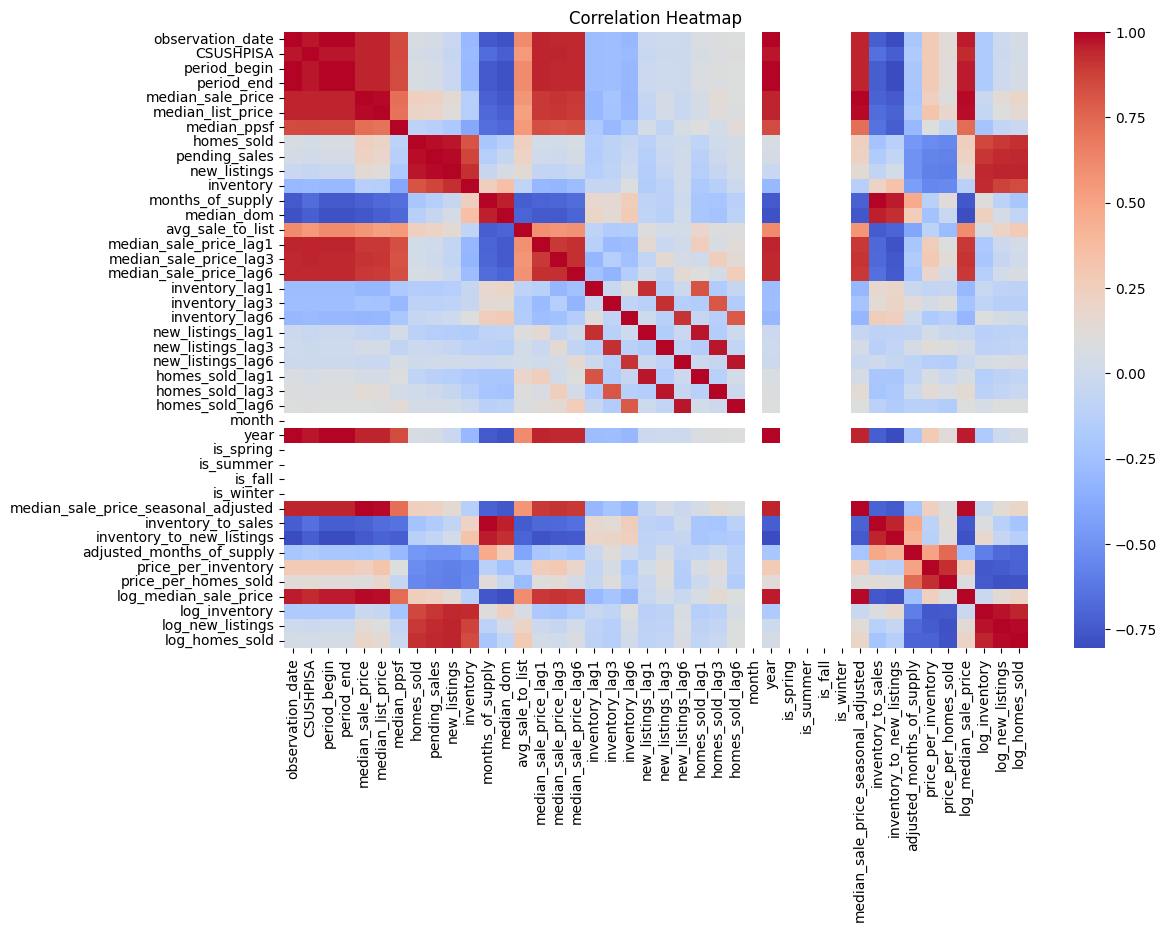

Feature Importances from Random Forest:
median_sale_price_lag1                 0.215062
median_sale_price_lag3                 0.201559
median_sale_price_seasonal_adjusted    0.121581
median_sale_price                      0.112257
median_list_price                      0.098923
log_median_sale_price                  0.098394
median_sale_price_lag6                 0.081887
inventory_to_new_listings              0.027977
median_ppsf                            0.019878
median_dom                             0.005702
inventory_to_sales                     0.004465
months_of_supply                       0.003806
adjusted_months_of_supply              0.001290
pending_sales                          0.001052
price_per_homes_sold                   0.000715
log_new_listings                       0.000655
price_per_inventory                    0.000649
inventory_lag6                         0.000567
inventory_lag1                         0.000492
new_listings                           0.000479


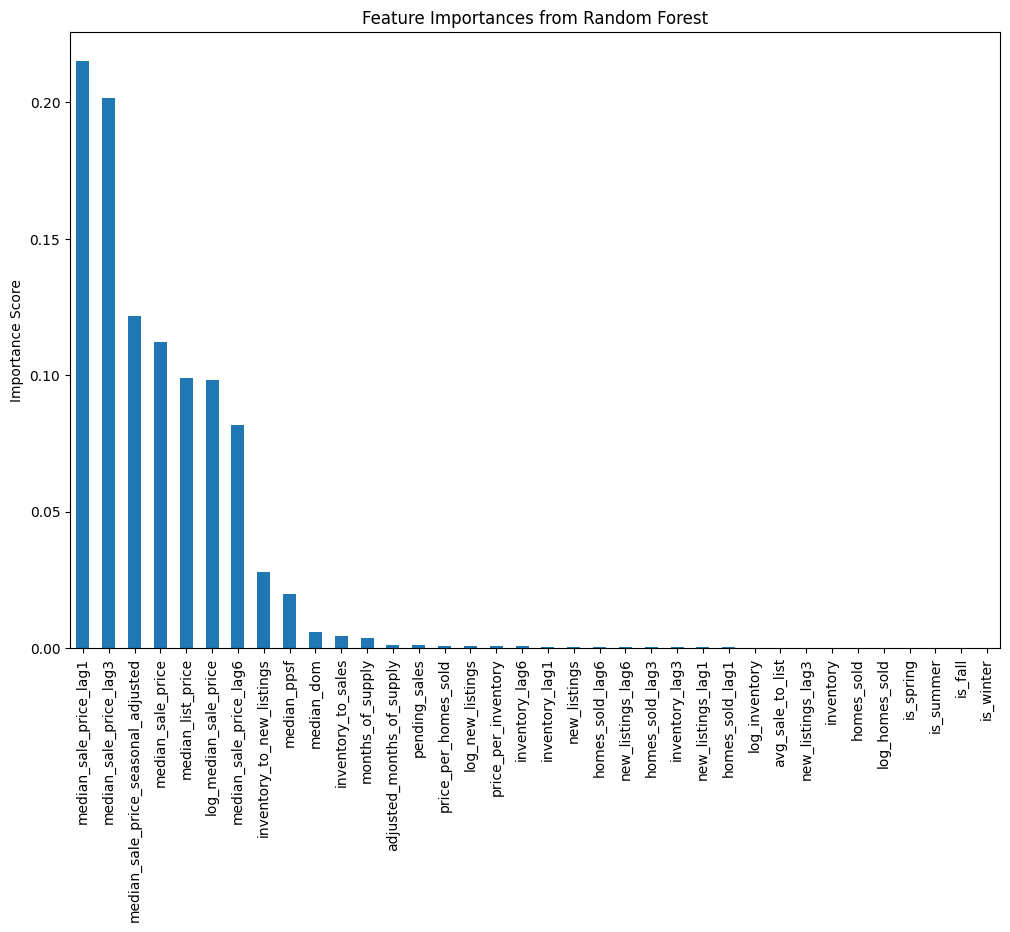

Variance Inflation Factor (VIF) Analysis:


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                Feature           VIF
0                     median_sale_price           inf
1                     median_list_price  3.794887e+02
2                           median_ppsf  1.025461e+01
3                            homes_sold  1.341754e+02
4                         pending_sales  3.404031e+02
5                          new_listings  6.711863e+02
6                             inventory  1.357116e+02
7                      months_of_supply  9.530194e+02
8                            median_dom  4.909919e+01
9                      avg_sale_to_list  3.662217e+00
10               median_sale_price_lag1  1.771170e+01
11               median_sale_price_lag3  1.772926e+01
12               median_sale_price_lag6  1.777905e+01
13                       inventory_lag1  3.257678e+01
14                       inventory_lag3  3.309400e+01
15                       inventory_lag6  3.227901e+01
16                    new_listings_lag1  1.254466e+02
17                    new_li

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [13]:
def feature_selection_and_preparation(df):
    # Step 1a: Correlation Analysis
    print("Correlation Analysis:")
    correlation_matrix = df.corr()
    target_corr = correlation_matrix["CSUSHPISA"].sort_values(ascending=False)
    print(target_corr)

    # Visualize correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # Step 1b: Feature Importance from Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Preparing features and target
    numerical_features = df.select_dtypes(include=["float64", "int64"]).drop("CSUSHPISA", axis=1)
    X = numerical_features
    y = df["CSUSHPISA"]

    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Feature Importances from Random Forest:")
    print(feature_importances)

    # Visualizing feature importances
    plt.figure(figsize=(12, 8))
    feature_importances.plot(kind="bar")
    plt.title("Feature Importances from Random Forest")
    plt.ylabel("Importance Score")
    plt.show()

    # Step 2: Multicollinearity (VIF Analysis)
    print("Variance Inflation Factor (VIF) Analysis:")
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

    # Drop features with high VIF (>10)
    features_to_keep = vif_data[vif_data["VIF"] <= 10]["Feature"].tolist()
    print(f"Selected Features after VIF Analysis: {features_to_keep}")

    # Step 3: Scaling and Normalization
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X[features_to_keep]), columns=features_to_keep)

    # Step 4: Final Dataset Preparation
    final_data = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)
    print("Final Data Prepared for Modeling:")
    print(final_data.head())

    return final_data, features_to_keep

# Applying feature selection and preparation
final_data, selected_features = feature_selection_and_preparation(enhanced_data)


`creating the final dataset with the features most affecting the CSUSHPISA`

In [14]:
final_features = [
    'year', 'median_sale_price_lag1', 'median_sale_price_lag3', 'median_sale_price_lag6',
    'median_sale_price', 'median_list_price', 'log_median_sale_price', 'median_ppsf',
    'homes_sold_lag1', 'homes_sold_lag3', 'inventory_to_sales', 'inventory_to_new_listings',
    'median_sale_price_seasonal_adjusted'
]

# Creating final dataset with selected features
final_data_selected = enhanced_data[final_features + ['CSUSHPISA']]  # Including target variable 'CSUSHPISA' for model training
final_data_selected

,year,median_sale_price_lag1,median_sale_price_lag3,median_sale_price_lag6,median_sale_price,median_list_price,log_median_sale_price,median_ppsf,homes_sold_lag1,homes_sold_lag3,inventory_to_sales,inventory_to_new_listings,median_sale_price_seasonal_adjusted,CSUSHPISA
0,2012,134703.00,170747.80,143553.55,152198.00,160420.00,11.932944,101.00,32672.00,395277.90,7.036442,4.028379,0.564327,136.6
1,2012,152198.00,165518.40,177702.15,148058.00,164294.00,11.905366,71.00,22090.00,31868.50,8.910852,4.598782,0.548976,136.6
2,2012,148058.00,134703.00,158876.00,171650.05,186478.55,12.053219,95.70,6865.00,32672.00,5.640796,4.072382,0.636452,136.6
3,2012,171650.05,152198.00,170747.80,165019.00,190335.00,12.013822,88.00,386652.05,22090.00,7.472938,4.260074,0.611865,136.6
4,2012,165019.00,148058.00,165518.40,159672.00,183524.00,11.980883,91.00,213083.00,6865.00,7.479624,4.236058,0.592039,136.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2024,418262.00,372750.65,438181.65,420538.95,431382.65,12.949295,231.90,7512.00,42489.25,2.749437,2.156304,1.559294,316.1
133,2024,420538.95,342486.00,416488.00,359118.00,383094.00,12.791409,221.00,416745.40,30694.00,2.977465,1.873553,1.331555,316.1
134,2024,359118.00,418262.00,400935.00,350781.50,363212.85,12.767922,309.15,29465.00,7512.00,3.415595,2.435281,1.300644,316.1
135,2024,350781.50,420538.95,372750.65,419986.15,430025.85,12.947979,233.05,43748.85,416745.40,2.732403,2.153204,1.557244,316.1


`correlation matrix`

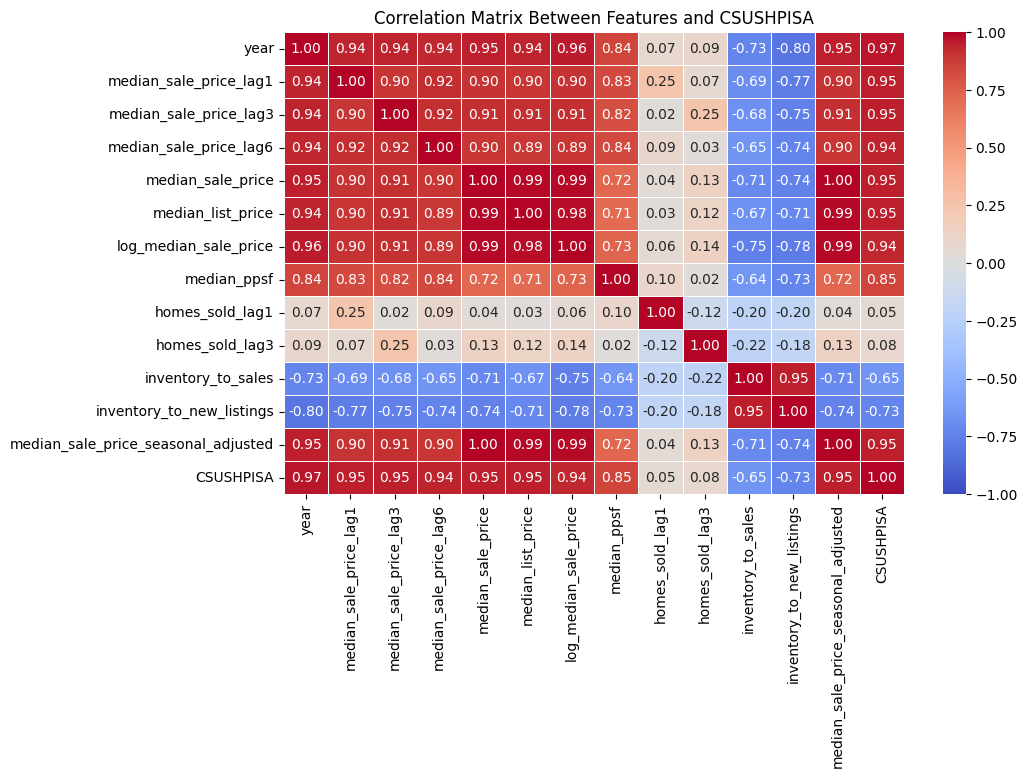

In [15]:
correlation_matrix = final_data_selected.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Between Features and CSUSHPISA')
plt.show()

_________________________

> ### `Model Selection & Training`
selecting the model with highest r-square, and having the  lowest mae, rmse values

`checking the scores for base models of Linear Regression
Decision Tree Random Forest XGBoost.`

In [16]:
X = final_data_selected.drop('CSUSHPISA', axis=1)  # Features
y = final_data_selected['CSUSHPISA']  # Target variable

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
models = {
       "Linear Regression": LinearRegression(),
       "Decision Tree": DecisionTreeRegressor(random_state=42),
       "Random Forest": RandomForestRegressor(random_state=42),
       "XGBoost": xgb.XGBRegressor(random_state=42)

   }
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Linear Regression trained.
Decision Tree trained.
Random Forest trained.
XGBoost trained.


`Result comparisions for all the models`

In [18]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append([name, r2, mae, rmse])

results_df = pd.DataFrame(results, columns=['Model', 'R²', 'MAE', 'RMSE'])
print("\nModel Comparison:")
print(results_df)


Model Comparison:
               Model        R²           MAE          RMSE
0  Linear Regression  0.972525  7.280401e+00  9.396792e+00
1      Decision Tree  1.000000  9.135549e-15  1.936613e-14
2      Random Forest  0.999041  1.244732e+00  1.755848e+00
3            XGBoost  1.000000  4.146031e-04  8.053193e-04


**Random Forest -** Seems to be the best suited model for our data with highest r-square value and lowest MAE and RMSE   
`Hyper parameter tunning the rf model to get the most effective results and also to avoid overfitting`

In [19]:
### finding the best parameters

rf = RandomForestRegressor(random_state=42)

# parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [20]:
rf_model = RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

R²: 0.9992023730006738
MAE: 1.0771821428567907
RMSE: 1.6010706066563858
